In [1]:
!pip install keras.layers.normalization

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.bfsu.edu.cn/pypi/web/simple
ERROR: Could not find a version that satisfies the requirement keras.layers.normalization (from versions: none)
ERROR: No matching distribution found for keras.layers.normalization


In [2]:
import zipfile
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Dense, TimeDistributed, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score
import matplotlib.pyplot as plt


In [3]:
# Step 1: Unzip the ZIP files
zip_filenames = ['Dengue-4-sequences.zip', 'Ebola-sequences.zip', 'SARS-CoV-2-sequences.zip', 'hepatitis-C-3a-sequences.zip', 'influenza-A-sequences.zip', 'mers-sequences.zip']

for zip_filename in zip_filenames:
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall()

fasta_filenames = [filename[:-4] for filename in zip_filenames]

In [4]:
# Step 2: Apply k-mer encoding
def k_mer_enc(filename: str, k: int):
    with open(filename + '.fasta', 'r') as file:
        seqs = []
        seq = ""
        for line in file.readlines():
            if line.startswith('>'):
                if len(seq) > 0:
                    seqs.append(seq)
                    seq = ""
            else:
                seq += line.strip('\n')
        if len(seq) > 0:
            seqs.append(seq)

        print(f'The file {filename} has {len(seqs)} sequences.')

        encodings = []
        for seq in seqs:
            encoding = []
            code = 0
            for c in seq:
                code *= 4
                if c == 'A':
                    code += 0
                if c == 'C':
                    code += 1
                if c == 'G':
                    code += 2
                if c == 'T':
                    code += 3
                code %= 4 ** k
                encoding.append(code)
            assert len(seq) == len(encoding), 'Error: Unmatched number of characters!'
            encodings.append(encoding)
        assert len(seqs) == len(encodings), 'Error: Unmatched number of sequences!'

        with open(filename + '.pkl', 'wb') as pkfile:
            pickle.dump(encodings, pkfile)

filenames = ['Dengue-4-sequences', 'Ebola-sequences', 'hepatitis-C-3a-sequences',
             'influenza-A-sequences', 'mers-sequences', 'SARS-CoV-2-sequences']
for filename in filenames:
    k_mer_enc(filename, 4)


The file Dengue-4-sequences has 3587 sequences.
The file Ebola-sequences has 4001 sequences.
The file hepatitis-C-3a-sequences has 3331 sequences.
The file influenza-A-sequences has 3669 sequences.
The file mers-sequences has 1633 sequences.
The file SARS-CoV-2-sequences has 4752 sequences.


In [5]:
# Step 3: Load encoded sequences and labels
data = []
labels = []
for i, filename in enumerate(filenames):
    with open(filename + '.pkl', 'rb') as pkfile:
        encodings = pickle.load(pkfile)
        data.extend(encodings)
        labels.extend([i] * len(encodings))

In [6]:
# Step 4: Pad sequences to the same length
max_seq_length = max([len(seq) for seq in data])
padded_data = tf.keras.preprocessing.sequence.pad_sequences(data, maxlen=max_seq_length, padding='post')

In [7]:
# Step 5: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_data, labels, test_size=0.2, stratify=labels, random_state=42)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [8]:
# Step 6: Reshape the data for ConvLSTM input
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], 1, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1, 1)

In [9]:
# Step 7: Create ConvLSTM model
from keras.layers import Flatten
def create_convlstm_model(input_shape, num_classes, learning_rate):
    model = Sequential([
        # ConvLSTM2D layer
        ConvLSTM2D(filters=64, kernel_size=(3, 1), activation='relu', padding='same', input_shape=input_shape, return_sequences=True),
        BatchNormalization(),

        # Second ConvLSTM2D layer
        ConvLSTM2D(filters=64, kernel_size=(3, 1), activation='relu', padding='same', return_sequences=True),
        BatchNormalization(),

        # TimeDistributed Flatten layer
        TimeDistributed(Flatten()),

        # Dense layer
        Dense(128, activation='relu'),
        Flatten(),  # r
        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    # Create an Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
early_stop = EarlyStopping(
    monitor='val_loss',  
    patience=4,  
    verbose=1,  
    restore_best_weights=True,  
)

In [12]:
# Step 8: Instantiate and train the model
learning_rate = 0.00001  # Set your desired learning rate
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2], X_train_reshaped.shape[3], X_train_reshaped.shape[4])
num_classes = np.unique(y_train).shape[0]
convlstm_model = create_convlstm_model(input_shape, num_classes, learning_rate)
history = convlstm_model.fit(X_train_reshaped, y_train_cat, epochs=20, batch_size=32, validation_split=0.2,callbacks=[early_stop])

2023-04-11 04:35:29.693565: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 04:35:30.233337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22310 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6


Epoch 1/20


2023-04-11 04:35:31.111724: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1636624992 exceeds 10% of free system memory.
2023-04-11 04:35:38.851909: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2023-04-11 04:35:40.945526: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


420/420 [==============================] - 111s 241ms/step - loss: 0.3590 - accuracy: 0.9224 - val_loss: 0.2627 - val_accuracy: 0.9368
Epoch 2/20
420/420 [==============================] - 99s 235ms/step - loss: 0.0927 - accuracy: 0.9743 - val_loss: 0.2173 - val_accuracy: 0.9467
Epoch 3/20
420/420 [==============================] - 99s 235ms/step - loss: 0.0396 - accuracy: 0.9886 - val_loss: 0.1256 - val_accuracy: 0.9639
Epoch 4/20
420/420 [==============================] - 99s 236ms/step - loss: 0.0218 - accuracy: 0.9934 - val_loss: 0.0800 - val_accuracy: 0.9812
Epoch 5/20
420/420 [==============================] - 98s 234ms/step - loss: 0.0270 - accuracy: 0.9920 - val_loss: 0.0862 - val_accuracy: 0.9791
Epoch 6/20
420/420 [==============================] - 99s 236ms/step - loss: 0.0155 - accuracy: 0.9954 - val_loss: 0.0629 - val_accuracy: 0.9893
Epoch 7/20
420/420 [==============================] - 99s 236ms/step - loss: 0.0141 - accuracy: 0.9958 - val_loss: 0.0566 - val_accuracy: 0.

In [13]:
convlstm_model.save('convlstm_model.h5')

In [14]:
# Step 9: Evaluate the model
test_loss, test_acc = convlstm_model.evaluate(X_test_reshaped, y_test_cat)
print(f'Test accuracy: {test_acc}')

132/132 [==============================] - 9s 71ms/step - loss: 0.0399 - accuracy: 0.9871
Test accuracy: 0.9871275424957275


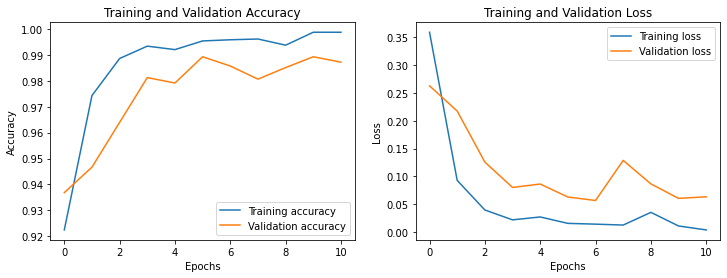

In [15]:
# Step 10: Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)


In [16]:
# Step 11: Analyze model performance using classification metrics
y_pred = convlstm_model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_classes))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_classes))

Confusion Matrix:
[[708   3   0   3   3   0]
 [  5 788   0   2   5   0]
 [  2   0 658   0   6   0]
 [  7   0   0 722   5   0]
 [ 10   1   1   1 314   0]
 [  0   0   0   0   0 951]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       717
           1       0.99      0.98      0.99       800
           2       1.00      0.99      0.99       666
           3       0.99      0.98      0.99       734
           4       0.94      0.96      0.95       327
           5       1.00      1.00      1.00       951

    accuracy                           0.99      4195
   macro avg       0.98      0.98      0.98      4195
weighted avg       0.99      0.99      0.99      4195



In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

# One-hot encode the test labels
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

# Evaluate the model on the test data
test_loss, test_acc = convlstm_model.evaluate(X_test_reshaped, y_test_cat)

# Make predictions on the test data
y_pred_probs = convlstm_model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)



132/132 [==============================] - 9s 71ms/step - loss: 0.0399 - accuracy: 0.9871


In [19]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
conf_mat = confusion_matrix(y_test, y_pred)

# Calculate specificity (True Negative Rate) for each class
specificity = []
for i in range(num_classes):
    tn = conf_mat[i, i]
    fn = np.sum(conf_mat[:, i]) - tn
    specificity.append(tn / (tn + fn))



In [29]:

# Calculate AUC score for each class
auc_scores = []
y_test_array = np.array(y_test)  # Convert y_test to a NumPy array
for i in range(num_classes):
    binary_y_true = (y_test_array == i).astype(int)
    binary_y_pred = y_pred_probs[:, i]
    auc = roc_auc_score(binary_y_true, binary_y_pred)
    auc_scores.append(auc)

print("Model Information:")
#print(f"Embedding Dimension: {embedding_dim}")
#print(f"Hidden Dimension: {hidden_dim}")
#print(f"Output Dimension: {output_dim}")
#print(f"No. of Layers: {num_layers}")
#print(f"Dropout: {dropout}")
#print(f"Optimizer: {optimizer}")
#print(f"No. of Epochs: {num_epochs}")
#print(f"Batch Size: {batch_size}")
#print(f"Max Vocab Size: {max_vocab_size}")
print("\nEvaluation Metrics:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc: {test_acc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("Precision: ", precision)
print("Recall: ", recall)
print("Specificity: ", specificity)
print("F1-score: ", f1)

print("\nAUC Scores:")

Model Information:

Evaluation Metrics:
Test Loss: 0.0399
Test Acc: 0.9871
Accuracy: 0.9871
Precision:  [0.96721311 0.99494949 0.99848255 0.99175824 0.94294294 1.        ]
Recall:  [0.9874477  0.985      0.98798799 0.98365123 0.96024465 1.        ]
Specificity:  [0.9672131147540983, 0.9949494949494949, 0.9984825493171472, 0.9917582417582418, 0.9429429429429429, 1.0]
F1-score:  [0.97722567 0.98994975 0.99320755 0.9876881  0.95151515 1.        ]

AUC Scores:


In [30]:

for i in range(num_classes):
    print(f"Class {i} vs. Other Classes: {auc_scores[i]:.4f}")

Class 0 vs. Other Classes: 0.9995
Class 1 vs. Other Classes: 0.9998
Class 2 vs. Other Classes: 1.0000
Class 3 vs. Other Classes: 0.9999
Class 4 vs. Other Classes: 0.9994
Class 5 vs. Other Classes: 1.0000


In [31]:
!pip install matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.bfsu.edu.cn/pypi/web/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 1.9 MB/s eta 0:00:00a 0:00:01


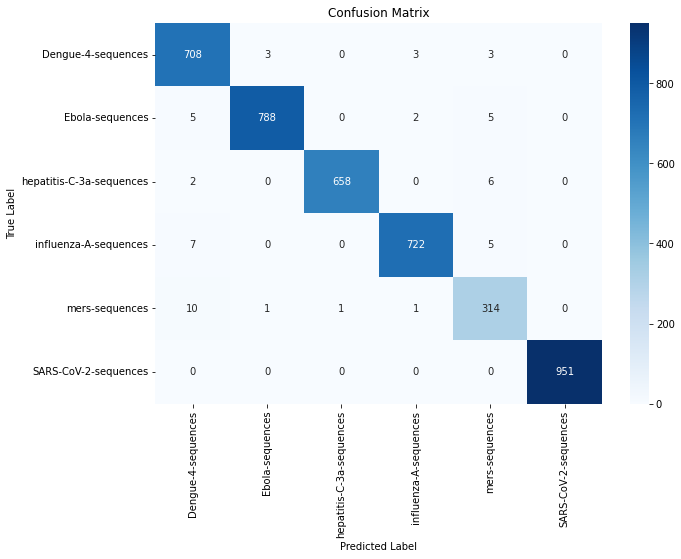

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Define your class names (replace these with your actual class names)
class_names = ['Dengue-4-sequences', 'Ebola-sequences', 'hepatitis-C-3a-sequences', 'influenza-A-sequences', 'mers-sequences', 'SARS-CoV-2-sequences']

# Assuming your confusion matrix variable is named `confusion_matrix`
plot_confusion_matrix(conf_mat, class_names)

In [34]:
convlstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 30484, 1, 64)   50176     
                                                                 
 batch_normalization (BatchN  (None, 1, 30484, 1, 64)  256       
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 30484, 1, 64)   98560     
                                                                 
 batch_normalization_1 (Batc  (None, 1, 30484, 1, 64)  256       
 hNormalization)                                                 
                                                                 
 time_distributed (TimeDistr  (None, 1, 1950976)       0         
 ibuted)                                                         
                                                        